<a href="https://colab.research.google.com/github/Kasyapsatya/Reserving_techniques/blob/main/Package.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Let's create a package in python
A package for Actuaries
A package for Actuarial Reserving devoloped from scratch
This already has the entire NAIC schedule P data analysed and also will be able to take data(with few-constraints) and generate the results into an excel sheet
"""
#current target: entered gr_code and line of business / uploaded new processed data, produce an excel sheet.

"\nLet's create a package in python\nA package for Actuaries\nA package for Actuarial Reserving devoloped from scratch\nThis already has the entire NAIC schedule P data analysed and also will be able to take data(with few-constraints) and generate the results into an excel sheet\n"

In [73]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import copy
import math
import matplotlib.pyplot as plt
#import streamlit as st

In [78]:
class triangle() :    #df is the pd dataframe pointing to the input file

  def get_triangle(self,df,gr,paid=0,reported=0,num_bootstrap_samples=1000):
    self.df=df
    self.pivottables = {}
    self.gr=gr
    for gr_code, group in df.groupby('GRCODE'):
        if paid==1:
          pivot_table = group.pivot_table(index='AccidentYear', columns='DevelopmentLag', values='CumPaidLoss')
          self.pivottables[self.gr] = pivot_table
          self.arima_pivottables = copy.deepcopy(self.pivottables)
          print("Upper Triangle:", self.pivottables[self.gr] )
          print()
          return self.pivottables
        if reported==1:
          pivot_table = group.pivot_table(index='AccidentYear', columns='DevelopmentLag', values='IncurLoss')
          self.pivottables[self.gr] = pivot_table
          self.arima_pivottables = copy.deepcopy(self.pivottables)
          print("Upper Triangle:", self.pivottables[self.gr] )
          print()
          return self.pivottables


  def init(self):
    for gr_code, pivot_table in self.pivottables.items():
      self.agefactors={}
      factors=[]
      for i in range(9):
        P = []
        for j in range(9):
          if (pivot_table.iloc[i,j] != 0):
            f = round(pivot_table.iloc[i,j+1]/pivot_table.iloc[i,j],4)
          elif (pivot_table.iloc[i,j] == 0 and pivot_table.iloc[i,j+1] == 0 ):
            f = 1
          else:
            f = None
          P.append(f)
        factors.append(P)
      Accident_Year = [1988+i for i in range(9)]
      col = [(12*(i+1),12*(i+2)) for i in range(9)]
      DF = pd.DataFrame.from_records(factors,columns = col, index = Accident_Year)
      self.agefactors[self.gr]=DF
      #print("Age-age factors:", self.agefactors[self.gr] )
      print()
    #def cap_ages(self):
    for gr_code, factors in self.agefactors.items():
      for i in range(9):
        his=[]
        for j in range(9):
          value=factors.iloc[j,i]
          try:
              del sum
          except :
              pass  #somewhere sum is defined as an integer
          if his:
            count=0
            for i in range(len(his)):
              count+=his[i]
            his_sum = count
            mean=his_sum/len(his)
            limit=mean+5
            if value>limit:
              factors.iloc[j,i]=mean
          his.append(factors.iloc[j,i])
      self.agefactors[self.gr]=factors
      #print("Age-Age factors:", self.agefactors[self.gr] )
      print()

    self.arima_agefactors={}
    p = 1  # AR order  #needs analysis
    d = 1  # Differencing order
    q = 1  # MA order
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for gr_code, factors in self.agefactors.items():
          j_list=[]
          for i in range(9):
            for j in range(9):
              if i+j>=9 and j not in j_list:
                data=list(factors.iloc[:,j])
                series = pd.Series(data)
                model = ARIMA(series, order=(p, d, q))
                fit_model = model.fit()
                predictions= np.array(fit_model.forecast(steps=j))
                k=0
                for i in range(j):
                  factors.iloc[9-j+i,j]= predictions[k]
                  k+=1
                j_list.append(j)
                  #factors.iloc[:,j]=np.array(data)+ np.array(fit_model.forecast(steps=j))
                #print("full updated data", np.array(factors.iloc[:,j]))
          self.arima_agefactors[self.gr]=factors
    #adding the row of 1997
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for gr_code, factors in self.arima_agefactors.items():
          AY= factors.index.tolist()
          new_row_data = {column: np.nan for column in self.df.columns}
          factors.loc[AY[-1]+1]= new_row_data
          for i in range(10):
                for j in range(9):
                  if i==9:
                    data=list(factors.iloc[:,j])
                    series = pd.Series(data)
                    #print("data", data)
                    model = ARIMA(series, order=(p, d, q))
                    fit_model = model.fit()
                    predictions= np.array(fit_model.forecast(steps=1))
                    #print("predictions",predictions)
                    factors.iloc[9,j]= predictions[0]
          self.arima_agefactors[self.gr]=factors
    #adding 120-Ult factor
    for gr_code, factors in self.arima_agefactors.items():
        factors['(120, Ult)']=1
    #print("ARIMA factors:", self.arima_agefactors[self.gr] )
    print()

    self.mean_age_factors={}
    for gr_code, factors in self.agefactors.items():
      mean=[]
      sum_=0
      num=0
      for i in range(9):
        for j in range(9):
          if not pd.isnull(factors.iloc[j, i]):
            sum_+=factors.iloc[j,i]
            num+=1
        mean.append(round((sum_/num),4))
        sum_=num=0
      mean.append(1)          #no extrapolation, assuming it is 1
      self.mean_age_factors[self.gr]=mean
      #print("Mean age factors:", self.mean_age_factors[self.gr] )
      print()


  def CDF(self):
    self.CDF={}
    for gr_code, dupl in self.mean_age_factors.items():
      mean=dupl.copy()
      for i in range(len(mean)):
        prod=1
        for j in range(i, len(mean)):
          prod*= mean[j]
        mean[i]=round(prod,4)
      self.CDF[self.gr]=mean
    #print("CDF:", self.CDF[self.gr] )
    print()
    return self.CDF
  def develop_triangle(self):
    for gr_code, pivot_table in self.pivottables.items() :
      #each pivot_table is a triangle, you have to fill the lower triangular values now
      #if devolopment lag+ AY >1998, then df[i,j]= df[i,j-1]*cdf[j]
      for i in range(pivot_table.shape[0]):
          for j in range(pivot_table.shape[1]):
            if i+j>9:
              pivot_table.iloc[i,j]=pivot_table.iloc[i,j-1]*self.mean_age_factors[self.gr][j-1]
    #print("Full Triangle:", self.pivottables[self.gr] )
    print()
    return self.pivottables
  def arima_develop_triangle(self):
    for gr_code, pivot_table in self.arima_pivottables.items() :
        #each pivot_table is a triangle, you have to fill the lower triangular values now
        #if devolopment lag+ AY >1998, then df[i,j]= df[i,j-1]*cdf[j]
        for i in range(pivot_table.shape[0]):
          for j in range(pivot_table.shape[1]):
            if i+j>9:
              pivot_table.iloc[i,j]=pivot_table.iloc[i,j-1]*self.arima_agefactors[gr_code].iloc[i,j-1]
        self.arima_pivottables[self.gr]=pivot_table
    return self.arima_pivottables

  def premium(self):
    self.premium = {}
    grouped = self.df.groupby('GRCODE')
    for gr_code, group_df in grouped:
        table = group_df.groupby('AccidentYear')['EarnedPremNet'].mean().reset_index()
        print(table)
        self.premium[self.gr] = table
        break
    #[1.338589096, 1.279143524, 1.20553075, 1.169688156, 1.136716145, 1.106310002, 1.077488464, 1.050814335, 1.017024053 ] got from https://www.bls.gov/data/inflation_calculator.htm
    for gr_code, table in self.premium.items():
      table['Onlevel factors']=np.array([1.338589096, 1.279143524, 1.20553075, 1.169688156, 1.136716145, 1.106310002, 1.077488464, 1.050814335, 1.017024053, 1 ])
      table['On level Premium']=table['EarnedPremNet']*table['Onlevel factors']
      self.premium[self.gr]=table
    #print("Premium:",self.premium[self.gr])
    print()
    return self.premium


class report():
  def reported(self,pivottables,gr,premium):  #needs reported triangle
    #need some information of CumRep
    self.premium=premium
    self.gr=gr
    self.reported={}
    self.capecod_ECR={}
    #print(pivottables[self.gr])
    for gr_code, pivot_table in pivottables.items():
      dev_c=[]
      dev_f=[]
      for i in range(pivot_table.shape[0]):
        for j in range(pivot_table.shape[1]):
          if i+j==9:
            dev_c.append(pivot_table.iloc[i,j])
          if j==9:
            dev_f.append(pivot_table.iloc[i,j])
      dev_c=np.array(dev_c)
      dev_f=np.array(dev_f)
      percentreported= dev_c/dev_f   #correct
      DF = pd.DataFrame()
      AY= pivot_table.index.tolist()
      DF['AccidentYear']= AY
      DF['On level premium']= self.premium[self.gr]['On level Premium']
      DF['cumrep']=dev_c     #cum reported as of current(1997/12/31)
      DF['pctrep'] =percentreported  #cum reported as of current(1997/12/31) using the devoloped triangle
      DF['Used-up Premium'] = self.premium[self.gr]['On level Premium'] *  DF['pctrep']
      self.reported[self.gr]=DF
      capecod_ecr= DF['cumrep'].sum() / DF['Used-up Premium'].sum()
      self.capecod_ECR[self.gr]=capecod_ecr
      #print(capecod_ecr)

      return self.reported, self.capecod_ECR


#self,df,gr,paid=0,reported=0

class method():
  def methods(self,df,gr,flag=0):
    if flag==1:
      Actuary_paid=triangle()
      self.pivottables_paid=df
    else:
      Actuary_validate=triangle()
      self.pivottables_verify=Actuary_validate.get_triangle(df,gr,paid=1) #for verification

      df = df[(df['AccidentYear'] + df['DevelopmentLag']) <= 1998]  #upper triangle
      #df.info()
      Actuary_paid=triangle()
      self.pivottables_paid=Actuary_paid.get_triangle(df,gr,paid=1)
      #bootstrapping here?

    Actuary_paid.init()
    self.pivottables_paid_devoloped= Actuary_paid.develop_triangle()
    self.pivottables_paid_devoloped_arima= Actuary_paid.arima_develop_triangle()
    self.premium=Actuary_paid.premium()
    self.CDF_paid=Actuary_paid.CDF()
    self.arima_pivottables_paid= Actuary_paid.arima_develop_triangle()

    Actuary_reported=triangle()
    self.pivottables_reported=Actuary_reported.get_triangle(df,gr,reported=1)
    Actuary_reported.init()
    self.pivottables_reported_devoloped= Actuary_reported.develop_triangle()
    self.pivottables_reported_devoloped_arima= Actuary_reported.arima_develop_triangle()
    self.CDF_reported=Actuary_reported.CDF()
    self.arima_pivottables_reported= Actuary_reported.arima_develop_triangle()

    Actuary_report=report()
    self.reported, self.capecod_ECR =Actuary_report.reported(self.pivottables_reported,gr,self.premium)

    self.gr=gr
    self.method={}
    self.accuracy={}
    self.UC={}

    for gr_code, pivot_table in self.pivottables_paid_devoloped.items():
      actual_reported_claims=[]
      dev_f_arima=[]
      dev_c=[]
      dev_f=[]
      Age=[]
      Premium=self.premium[self.gr]['EarnedPremNet']
      Premium=np.array(Premium)
      onlevelPremium=self.premium[self.gr]['On level Premium']
      onlevelPremium=np.array(onlevelPremium)
      for i in range(pivot_table.shape[0]):
        for j in range(pivot_table.shape[1]):
          if i+j==9:
            dev_c.append(pivot_table.iloc[i,j])
            actual_reported_claims.append(self.pivottables_reported[self.gr].iloc[i,j])
          if j==9:
            dev_f.append(pivot_table.iloc[i,j])
            dev_f_arima.append(self.arima_pivottables_paid[gr_code].iloc[i,j])
      for i in range(pivot_table.shape[1],0,-1):
        Age.append(12*i)
      ibnr=np.array(dev_f) - np.array(dev_c)
      actual_reported_claims=np.array(actual_reported_claims)
      dev_c=np.array(dev_c)
      dev_f=np.array(dev_f)
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="invalid value encountered in divide")
        ecratio = np.array(dev_f) / Premium
      ecr_1=[]
      ecr_2=[]
      for i in range(pivot_table.shape[0]//2):
        ecr_1.append(ecratio[i])
      ecr_1mean=sum(ecr_1)/len(ecr_1)
      for i in range(pivot_table.shape[0]//2,pivot_table.shape[0]):
        ecr_2.append(ecratio[i])
      ecr_2mean=sum(ecr_2)/len(ecr_2)
      selected_ecr1 = [ecr_1mean] *(pivot_table.shape[0]//2)
      selected_ecr2 = [ecr_2mean] *(pivot_table.shape[0]//2)
      selected_ecr= selected_ecr1+ selected_ecr2
      selected_ecr=np.array(selected_ecr)
      Exp_Ult= Premium * selected_ecr
      cd_factors=np.array(self.CDF_paid[self.gr])
      reported_pct=dev_c/dev_f           #########done
      #print("Reported %",reported_pct)
      #print(Exp_Ult)
      DF = pd.DataFrame()
      AY= pivot_table.index.tolist()
      DF['AccidentYear']= AY
      DF['Age']=Age
      DF['Devolopment as of end of {}'.format(AY[0])]=dev_c
      DF['Chain Ladder']= dev_f
      DF['ARIMA Chain Ladder']= dev_f_arima
      #DF['IBNR paid chainladder']=ibnr
      DF['Premium']=Premium
      DF['EC ratio']= ecratio
      DF['Selected EC ratio'] =selected_ecr
      DF['Expected Ult Loss']= Exp_Ult
      DF['CDF']=cd_factors
      DF['BF']= (dev_c) + ((1-reported_pct)* Exp_Ult)   ######
      #print(capecod_ECR[gr_code])
      DF['On level premium']= onlevelPremium
      DF['capecodECR']=self.capecod_ECR[self.gr]
      #DF['ECR expected paid claims']= ((1-reported_pct)* Exp_Ult)
      expected_unreported_claims= np.array((onlevelPremium* self.capecod_ECR[self.gr])*(1-self.reported[self.gr]['pctrep']))
      DF['Cape-cod Ult paid claims']=   actual_reported_claims+  expected_unreported_claims
      DF['Original UC']= np.array(self.pivottables_verify[self.gr].iloc[:,-1])
      #DF['Cape-cod Ult paid check']=   (dev_c) + ((capecod_ECR[gr_code])* Exp_Ult)
      #DF['IBNR capecod']= DF['UC capecod']*(1-reported[gr_code]['pctrep'])
      r2_1 = r2_score( np.array(DF['Original UC']), np.array(DF['Chain Ladder']))
      r2_2 = r2_score( np.array(DF['Original UC']), np.array(DF['ARIMA Chain Ladder']))
      r2_3 = r2_score( np.array(DF['Original UC']), np.array(DF['Expected Ult Loss']))
      r2_4 = r2_score( np.array(DF['Original UC']), np.array(DF['BF']))
      r2_5= r2_score( np.array(DF['Original UC']), np.array(DF['Cape-cod Ult paid claims']))
      self.accuracy['Chain Ladder']=r2_1
      self.accuracy['ARIMA Chain Ladder']=r2_2
      self.accuracy['Expected Ult Loss']=r2_3
      self.accuracy['BF']=r2_4
      self.accuracy['Cape-cod Ult paid claims']=r2_5
      #print(DF.columns)

      self.UC['Chain Ladder']= DF['Chain Ladder'].sum()
      self.UC['ARIMA Chain Ladder']=DF['ARIMA Chain Ladder'].sum()
      self.UC['Expected Ult Loss']=DF['Expected Ult Loss'].sum()
      self.UC['BF']=DF['BF'].sum()
      self.UC['Cape-cod Ult paid claims']=DF['Cape-cod Ult paid claims'].sum()
      self.UC['Original UC']=DF['Original UC'].sum()

      columns=['Original UC', 'Cape-cod Ult paid claims', 'BF', 'Expected Ult Loss', 'ARIMA Chain Ladder', 'Chain Ladder']

      for i in range(1,len(columns)):
        plt.figure(figsize=(5, 3))
        plt.plot(DF['AccidentYear'], DF[columns[i]], label=columns[i])
        plt.plot(DF['AccidentYear'], DF[columns[0]], label=columns[0])
        plt.xlabel('Accident Year')
        plt.ylabel('Projection')
        plt.title('Comparison: {}. R2={}'.format(columns[i],self.accuracy[columns[i]]))

        plt.legend()
      #print(DF['Cape-cod Ult paid claims'].sum())
      #print(DF['Original UC'].sum())

      self.method[self.gr]=DF

    return self.method, self.accuracy, self.UC



Upper Triangle: DevelopmentLag    1     2      3      4      5      6      7      8      9   \
AccidentYear                                                                  
1988            3894  7409  11199  16913  18517  19722  20417  20902  21208   
1989            3883  6869  10489  14410  16605  18485  20112  20654  20835   
1990            4178  7473  11281  15874  19186  20993  22069  22477  22742   
1991            3872  8137  14577  18071  22125  23770  24559  25283  26017   
1992            4095  7260  11015  14844  19309  20097  20927  21138  21424   
1993            2223  4048   6651   8229   9141  10446  11078  11098  11510   
1994            2500  4003   6893   9379  11092  11386  11602  11684  12304   
1995            2442  4657   7303   8380   9553  10170  10446  10522  10618   
1996            2761  4661   7009  10018  11108  12333  13023  13131  14071   
1997            2642  5027   9539  12343  15013  16282  16917  17105  17236   

DevelopmentLag     10  
AccidentYea

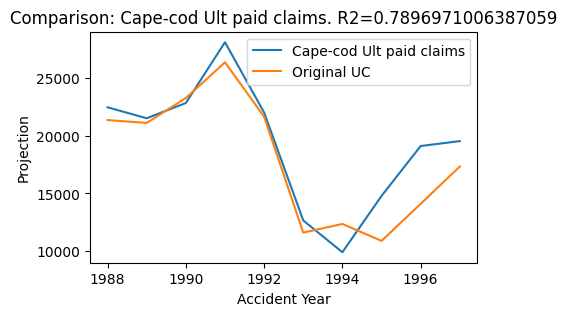

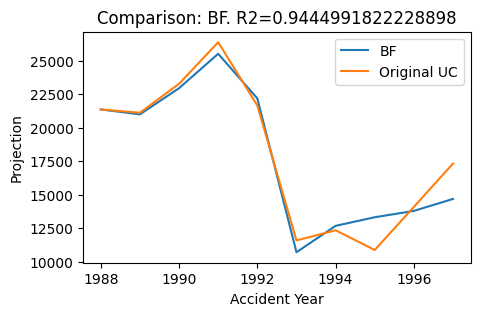

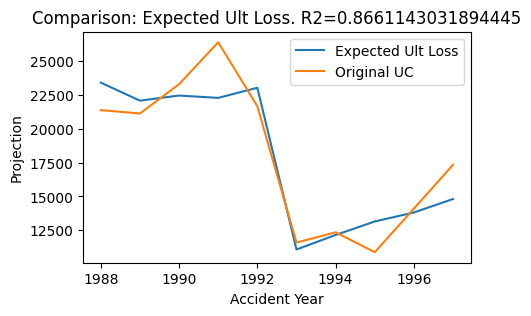

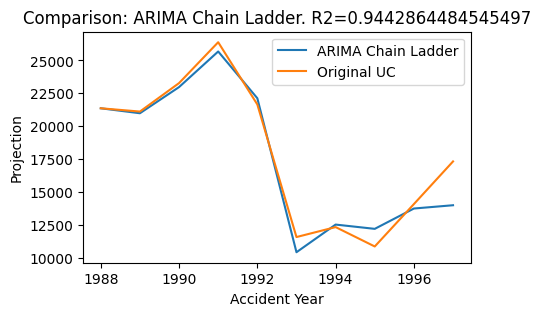

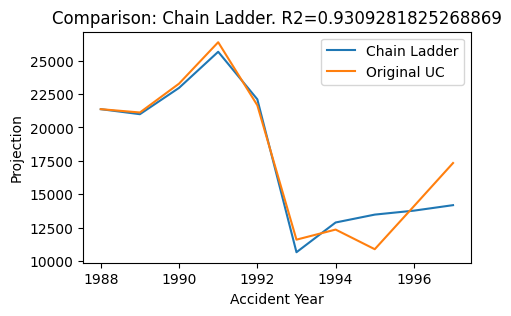

In [79]:
df = pd.read_csv('/content/drive/MyDrive/Actuary/Project- Reserving/merged_data.csv')
df = df[df['Line_of_Business_LOB5'] == 1]
df_filtered= df[(df['AccidentYear'] + df['DevelopmentLag']) <= 1998] #upper trianlge
#take a company code
gr=78 #44504
Actuary=method()
results=[Actuary.methods(df,gr)]
print(results)
#results[0][2]['Chain Ladder'] is our chianladder UC reserve estimate

In [80]:
#for triangular data      DONE
class triangle_tri() :
  def get_triangle(self,Triangle,gr,num_bootstrap_samples=1000,paid=0,reported=0):
    self.gr=gr
    self.pivottables = {}
    if paid==1:
      pivot_table = Triangle
      self.pivottables[self.gr] = pivot_table
      self.arima_pivottables = copy.deepcopy(self.pivottables)
      #print("Upper Triangle:", self.pivottables[self.gr] )
      return self.pivottables
    if reported==1:
      pivot_table = Triangle
      self.pivottables[self.gr] = pivot_table
      self.arima_pivottables = copy.deepcopy(self.pivottables)
      #print("Upper Triangle:", self.pivottables[self.gr] )
      return self.pivottables


  def init(self,df):
    self.df=df
    for gr_code, pivot_table in self.pivottables.items():
      self.agefactors={}
      factors=[]
      for i in range(9):
        P = []
        for j in range(9):
          if (pivot_table.iloc[i,j] != 0):
            f = round(pivot_table.iloc[i,j+1]/pivot_table.iloc[i,j],4)
          elif (pivot_table.iloc[i,j] == 0 and pivot_table.iloc[i,j+1] == 0 ):
            f = 1
          else:
            f = None
          P.append(f)
        factors.append(P)
      Accident_Year = [1988+i for i in range(9)]
      col = [(12*(i+1),12*(i+2)) for i in range(9)]
      DF = pd.DataFrame.from_records(factors,columns = col, index = Accident_Year)
      self.agefactors[self.gr]=DF
      #print("Age-age factors:", self.agefactors[self.gr] )
    #def cap_ages(self):
    for gr_code, factors in self.agefactors.items():
      for i in range(9):
        his=[]
        for j in range(9):
          value=factors.iloc[j,i]
          try:
              del sum
          except :
              pass  #somewhere sum is defined as an integer
          if his:
            count=0
            for i in range(len(his)):
              count+=his[i]
            his_sum = count
            mean=his_sum/len(his)
            limit=mean+5
            if value>limit:
              factors.iloc[j,i]=mean
          his.append(factors.iloc[j,i])
      self.agefactors[self.gr]=factors
      #print("Age-Age factors:", self.agefactors[self.gr] )

    self.mean_age_factors={}
    for gr_code, factors in self.agefactors.items():
      mean=[]
      sum_=0
      num=0
      for i in range(9):
        for j in range(9):
          if not pd.isnull(factors.iloc[j, i]):
            sum_+=factors.iloc[j,i]
            num+=1
        mean.append(round((sum_/num),4))
        sum_=num=0
      mean.append(1)          #no extrapolation, assuming it is 1
      self.mean_age_factors[self.gr]=mean
      #print("Mean age factors:", self.mean_age_factors[self.gr] )


  def CDF(self):
    self.CDF={}
    for gr_code, dupl in self.mean_age_factors.items():
      mean=dupl.copy()
      for i in range(len(mean)):
        prod=1
        for j in range(i, len(mean)):
          prod*= mean[j]
        mean[i]=round(prod,4)
      self.CDF[self.gr]=mean
    #print("CDF:", self.CDF[self.gr] )
    return self.CDF
  def develop_triangle(self):
    for gr_code, pivot_table in self.pivottables.items() :
      #each pivot_table is a triangle, you have to fill the lower triangular values now
      #if devolopment lag+ AY >1998, then df[i,j]= df[i,j-1]*cdf[j]
      for i in range(pivot_table.shape[0]):
          for j in range(pivot_table.shape[1]):
            if i+j>9:
              pivot_table.iloc[i,j]=pivot_table.iloc[i,j-1]*self.mean_age_factors[self.gr][j-1]
    #print("Full Triangle:", self.pivottables[self.gr] )
    return self.pivottables

#self,df,gr,paid=0,reported=0

class method_triangle():
  def init(self,df,gr,tri_paid,pivottables):
    self.tri_paid=tri_paid
    self.df=df
    self.pivottables=pivottables
    self.gr=gr

  def methods(self):
    Actuary_paid=triangle_tri()
    self.pivottables_paid=Actuary_paid.get_triangle(self.tri_paid,self.gr,paid=1)
    #undeveloped= copy.deepcopy(self.pivottables)
    Actuary_paid.init(self.df)
    self.pivottables_paid_devoloped= Actuary_paid.develop_triangle()
    self.CDF_paid=Actuary_paid.CDF()
    self.gr=gr
    self.method={}
    self.UC={}

    for gr_code, pivot_table in self.pivottables_paid_devoloped.items():
      dev_c=[]
      dev_f=[]
      Age=[]
      for i in range(pivot_table.shape[0]):
        for j in range(pivot_table.shape[1]):
          if i+j==9:
            dev_c.append(pivot_table.iloc[i,j])
          if j==9:
            dev_f.append(pivot_table.iloc[i,j])
      for i in range(pivot_table.shape[1],0,-1):
        Age.append(12*i)
      ibnr=np.array(dev_f) - np.array(dev_c)
      dev_c=np.array(dev_c)
      dev_f=np.array(dev_f)
      cd_factors=np.array(self.CDF_paid[self.gr])
      DF = pd.DataFrame()
      AY= pivot_table.index.tolist()
      DF['AccidentYear']= AY
      DF['Age']=Age
      DF['Devolopment as of end of {}'.format(AY[0])]=dev_c
      DF['Chain Ladder']= dev_f
      DF['CDF']=cd_factors

      self.UC['Chain Ladder']= DF['Chain Ladder'].sum()

      columns=[ 'Chain Ladder']

      for i in range(1,len(columns)):
        plt.figure(figsize=(5, 3))
        plt.plot(DF['AccidentYear'], DF[columns[i]], label=columns[i])
        plt.xlabel('Accident Year')
        plt.ylabel('Projection')
        plt.title('Comparison: {}'.format(columns[i]) )
        plt.legend()
      self.method[self.gr]=DF
    return self.method, self.UC


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Actuary/Project- Reserving/merged_data.csv')
df = df[df['Line_of_Business_LOB5'] == 1]
df_filtered= df[(df['AccidentYear'] + df['DevelopmentLag']) <= 1998] #upper trianlge
#take a company code
gr=78 #44504
Actuary=method_triangle()
pivottables={}
for gr_code, group in df_filtered.groupby('GRCODE'):
      if gr_code==gr:
            pivot_table = group.pivot_table(index='AccidentYear', columns='DevelopmentLag', values='CumPaidLoss')
            pivottables[gr] = pivot_table
            #print("Upper Triangle:", pivottables[gr] )
            tri_paid=pivottables[gr]
triangle_array = tri_paid.values.copy()
Actuary.init(df_filtered,gr,tri_paid,pivottables)
results=[Actuary.methods()]
print(results[0][1]['Chain Ladder']) #is our chianladder UC reserve estimate

In [197]:
triangle_array = [[value for value in row if not np.isnan(value)] for row in triangle_array]
num_samples = 1000
reserve_estimates=[]
# Define the block size (e.g., number of years)
block_size = 10  # Assuming each row represents a year

# Perform block bootstrapping
bootstrapped_samples = []
for _ in range(num_samples):
    # Resample blocks with replacement
    sampled_blocks = []
    for i in range(10):
        sampled_block = np.random.choice(triangle_array[i], size=len(triangle_array[i]), replace=True)
        sampled_blocks.append(sampled_block)
    max_length = max(len(arr) for arr in sampled_blocks)
    homogeneous_arrays = [np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=np.nan) for arr in sampled_blocks]
    homogeneous_arrays = np.vstack(homogeneous_arrays)
    #print(homogeneous_arrays)

    Actuary=method_triangle()
    new_df = pd.DataFrame(homogeneous_arrays, index=tri_paid.index, columns=tri_paid.columns)
    pivottables={}
    pivottables[gr]=new_df
    Actuary.init(df_filtered,gr,new_df,pivottables)
    results=[Actuary.methods()]
    #print(results[0][1]['Chain Ladder'],"is the estimate")
    reserve_estimates.append(results[0][1]['Chain Ladder'])

# Now bootstrapped_samples contains num_samples bootstrapped actuarial triangles
print(reserve_estimates)
reserve_estimates = np.array(reserve_estimates)

# Calculate statistics of bootstrap samples
mean_reserve = np.mean(reserve_estimates, axis=0)
std_dev_reserve = np.std(reserve_estimates, axis=0)

print("Mean Reserve Estimates:", mean_reserve)
print("Standard Deviation of Reserve Estimates:", std_dev_reserve)

[16647.18011380275, 69941.8720209598, 60360.03869230841, 555323.7110291687, 276911.1522698465, 264933.00348942465, 226868.27130144718, 199997.5144277857, 215703.86297188446, 274203.28568879137, 194580.69401328053, 64846.52734055087, 204186.16103053093, 133105.5179511245, 38602.99412526305, 167882.30410142647, 757714.7490289726, 261616.61307095745, 218126.1949969508, 162710.34445514585, 203984.61303470202, 391525.74209106085, 1190107.1786402946, 155446.51218991022, 123224.31502412003, 221553.24508482678, 155912.48755540577, 237424.17882917417, 23899.542956916885, 123637.91515615326, 253672.77654451565, 111465.55577438633, 179931.95337742733, 226932.4813904759, 82004.31515996647, 175261.17445834106, 140412.46781970427, 141574.2014495405, 208986.49125538522, 262851.6258146419, 30485.830700065275, 141454.59308442177, 416056.44881767826, 173155.59225717845, 185631.98603878863, 242973.33000416655, 141860.95543149172, 276875.7017338469, 26386.64961367622, 51909.97671115993, 288609.7010975522,